In [1]:
# import the necessnary libs
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
import urllib
from google.colab import drive
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

The following code cells showing the technique of data mining and preprocessing. The preprocessed data has been uploaded to the folder. Hence, these section are for reference only.<br><br>

For the models, please follow this link:<br>
[Model](#model)

Or click the Model section on the content.


# Data Mining/Scrpting

In [ ]:
import requests
URL = 'https://racing.hkjc.com/racing/information/English/Racing/ResultsAll.aspx?RaceDate=2010/09/05'
page = requests.get('https://racing.hkjc.com/racing/information/chinese/Racing/ResultsAll.aspx?RaceDate=2010/09/05')

In [ ]:
# Solve the math game in the web page
from math import cos, pi, floor

import requests

def parse_challenge(page):
    """
    Parse a challenge given by mmi and mavat's web servers, forcing us to solve
    some math stuff and send the result as a header to actually get the page.
    This logic is pretty much copied from https://github.com/R3dy/jigsaw-rails/blob/master/lib/breakbot.rb
    """
    top = page.split('<script>')[1].split('\n')
    challenge = top[1].split(';')[0].split('=')[1]
    challenge_id = top[2].split(';')[0].split('=')[1]
    return {'challenge': challenge, 'challenge_id': challenge_id, 'challenge_result': get_challenge_answer(challenge)}


def get_challenge_answer(challenge):
    """
    Solve the math part of the challenge and get the result
    """
    arr = list(challenge)
    last_digit = int(arr[-1])
    arr.sort()
    min_digit = int(arr[0])
    subvar1 = (2 * int(arr[2])) + int(arr[1])
    subvar2 = str(2 * int(arr[2])) + arr[1]
    power = ((int(arr[0]) * 1) + 2) ** int(arr[1])
    x = (int(challenge) * 3 + subvar1)
    y = cos(pi * subvar1)
    answer = x * y
    answer -= power
    answer += (min_digit - last_digit)
    answer = str(int(floor(answer))) + subvar2
    return answer


def getPage(URL):
  if __name__ == '__main__':
    s = requests.Session()
    r = s.get(URL)

    if 'X-AA-Challenge' in r.text:
        challenge = parse_challenge(r.text)
        r = s.get(URL, headers={
            'X-AA-Challenge': challenge['challenge'],
            'X-AA-Challenge-ID': challenge['challenge_id'],
            'X-AA-Challenge-Result': challenge['challenge_result']
        })

        yum = r.cookies
        r = s.get(URL, cookies=yum)

    return r

In [ ]:
import requests, re
from bs4 import BeautifulSoup
from urllib.parse import urljoin

table_source = "https://racing.hkjc.com/racing/information/English/Horse/HorseFormerName.aspx"
start_url = "https://racing.hkjc.com"

page = getPage(table_source)

In [ ]:
# Extract the Link regarding the information of each horse
horse_info_links = []
soup = BeautifulSoup(page.text, 'html.parser')
table = BeautifulSoup(str(soup.find_all(class_='bigborder')))
links = table.find_all('a', href=re.compile("HorseId="))
for item in links:
    horse_info_links.append(urljoin(start_url, item['href']))
print(horse_info_links)
URL = horse_info_links[0]
name=URL.split("=")[1].split("_", 1)[1]
print(name)

In [ ]:
def horse_df(URL):
  name=URL.split("=")[1].split("_", 1)[1]
  page = getPage(URL)
  soup = BeautifulSoup(page.text, 'html.parser')
  table = soup.find_all(class_='bigborder')
  df = pd.read_html(str(table))

  df=df[0]
  df.columns=df.iloc[0]
  df=df.drop(0)
  df=df.drop(columns='VideoReplay')
  df['horse']=name

  df['season']=0
  for ind in range(len(df)):
    ind=ind+1
    if (df['G'][ind] == df['Dist.'][ind]):
      c = df['G'][ind][:5]
    df['season'][ind]=c
  df['N_RaceIndex']=df['season']+"_"+df['RaceIndex']

  for ind in range(len(df)):
    ind=ind+1
    if (df['G'][ind] == df['Dist.'][ind]):
      df['G'][ind]="NaN"
  indexNames = df[ df['G'] == "NaN" ].index
  df.drop(indexNames , inplace=True)
  return df

In [ ]:
# read tables of all horses using the hourses_id extracted eariler
df_list = []
import warnings
from time import time
warnings.filterwarnings("ignore")
start_time = time()
for link in horse_info_links:
    try:
        df = horse_df(link)
        df_list.append(df)
    except:
        continue
    print(f"Progress: {len(df_list)}/{len(horse_info_links)}")
    print(f"Time used: {time() - start_time}")
    print("=" * 20)

result = pd.concat(df_list)
result = result.reset_index(drop=True)


In [ ]:
result.to_csv("horse_info.csv")
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15017 entries, 0 to 15016
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   RaceIndex         15017 non-null  object
 1   Pla.              15017 non-null  object
 2   Date              15017 non-null  object
 3   RC/Track/Course   15017 non-null  object
 4   Dist.             15017 non-null  object
 5   G                 15017 non-null  object
 6   RaceClass         15017 non-null  object
 7   Dr.               15017 non-null  object
 8   Rtg.              15017 non-null  object
 9   Trainer           15017 non-null  object
 10  Jockey            15009 non-null  object
 11  LBW               15017 non-null  object
 12  Win Odds          15017 non-null  object
 13  Act.Wt.           15017 non-null  object
 14  RunningPosition   15017 non-null  object
 15  Finish Time       15017 non-null  object
 16  Declar.Horse Wt.  15017 non-null  object
 17  Gear        

# Data Preprocessing

## Load horse_info

In [ ]:
### Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')
### Load data from drive
horse_info = pd.read_csv("drive/MyDrive/COMP3359 Project/horse_info.csv")
horse_info

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,0,RaceIndex,Pla.,Date,RC/Track/Course,Dist.,G,RaceClass,Dr.,Rtg.,Trainer,Jockey,LBW,Win Odds,Act.Wt.,RunningPosition,Finish Time,Declar.Horse Wt.,Gear,horse,season,N_RaceIndex
0,0,452,11,24/2/2021,"HV / Turf / ""C+3""",1650,GF,4,10,60,L Ho,H T Mo,13/1/2002,150,130,2 2 2 11,1.42.71,1217,B/TT-,2019_D466,20/21,20/21_452
1,1,334,14,10/1/2021,"ST / Turf / ""C""",1600,G,3,14,64,L Ho,C Wong,21/1/2002,396,112,3 2 11 14,1.37.64,1222,B1/TT,2019_D466,20/21,20/21_334
2,2,263,12,13/12/2020,"ST / Turf / ""A""",1400,G,3,9,67,L Ho,H T Mo,9/3/2004,346,118,14 13 13 12,1.23.18,1238,TT1,2019_D466,20/21,20/21_263
3,3,192,14,14/11/2020,"ST / Turf / ""C+3""",1400,G,3,7,70,L Ho,H T Mo,9,320,115,11 10 12 14,1.22.99,1253,--,2019_D466,20/21,20/21_192
4,4,120,12,18/10/2020,"ST / Turf / ""B+2""",1400,GF,3,9,72,L Ho,H T Mo,6,163,125,12 9 7 12,1.23.02,1223,--,2019_D466,20/21,20/21_120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15012,15012,117,13,21/10/2018,"ST / Turf / ""A""",1200,GF,3,7,72,W Y So,C Murray,7/3/2004,252,125,12 13 13,1.10.45,1060,H1/TT1,2017_B406,18/19,18/19_117
15013,15013,542,3,28/3/2021,"ST / Turf / ""A+3""",1400,GF,4,7,59,J Size,B Shinn,3,4.8,132,12 10 5 3,1.21.62,1031,H/P/TT,2019_D415,20/21,20/21_542
15014,15014,463,1,28/2/2021,"ST / Turf / ""B+2""",1400,G,4,2,53,J Size,B Shinn,1/1/2004,5.3,128,9 7 6 1,1.22.13,1028,H/P/TT,2019_D415,20/21,20/21_463
15015,15015,390,6,31/1/2021,"ST / Turf / ""B+2""",1400,G,4,9,53,J Size,A Badel,2,13,127,11 12 13 6,1.22.53,1042,H/P/TT,2019_D415,20/21,20/21_390


In [ ]:
# We define a function to do basic preprocessing for data exploration

def time_map(org_time):
    splited_time = org_time.split(".")
    calculated_time = int(splited_time[0])*60*100 + int(splited_time[1])*100 + int(splited_time[2])
    return calculated_time

def horse_info_preprocess(df):
    df['RC'] = df['RC/Track/Course'].str.split("/", expand=True)[0]
    df['Track'] = df['RC/Track/Course'].str.split("/", expand=True)[1]
    df['Course'] = df['RC/Track/Course'].str.split("/", expand=True)[2]
    df.drop(["0","RaceIndex", "RunningPosition", "RC/Track/Course", "Date", "LBW","season"], axis=1, inplace=True)
    
    #df.drop(["Pla.","N_RaceIndex"], axis=1, inplace=True)
    
    df.replace("--", np.NaN, inplace=True)
    df = df[df['Finish Time'].notna()]
    df["Gear"].fillna("None")
    df['NoofGear']=0
    for ind in df.index:
      if (df['Gear'][ind]!='NaN'):
        try:
          df['NoofGear'][ind]=len(df['Gear'][ind])
        except:
          continue

    df[["Win Odds", "Declar.Horse Wt.","Rtg.","Dr."]] = df[["Win Odds", "Declar.Horse Wt.","Rtg.","Dr."]].apply(pd.to_numeric)
    
    df["Finish Time"] = df["Finish Time"].map(time_map)

    return df

In [ ]:
horse_info_processed1=horse_info_preprocess(horse_info)

In [ ]:
horse_info_processed1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14794 entries, 0 to 15016
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Pla.              14794 non-null  object 
 1   Dist.             14794 non-null  int64  
 2   G                 14794 non-null  object 
 3   RaceClass         14794 non-null  object 
 4   Dr.               14794 non-null  int64  
 5   Rtg.              14741 non-null  float64
 6   Trainer           14794 non-null  object 
 7   Jockey            14794 non-null  object 
 8   Win Odds          14782 non-null  float64
 9   Act.Wt.           14794 non-null  int64  
 10  Finish Time       14794 non-null  int64  
 11  Declar.Horse Wt.  14791 non-null  float64
 12  Gear              11509 non-null  object 
 13  horse             14794 non-null  object 
 14  N_RaceIndex       14794 non-null  object 
 15  RC                14794 non-null  object 
 16  Track             14794 non-null  object

In [ ]:
for i in horse_info_processed1.columns:
  try:
    print("------------",i,"------------")
    print(horse_info_processed1[i].describe())
  except:
    continue

------------ Pla. ------------
count     14794
unique       14
top           1
freq       1397
Name: Pla., dtype: object
------------ Dist. ------------
count    14794.000000
mean      1387.636880
std        272.285467
min       1000.000000
25%       1200.000000
50%       1400.000000
75%       1650.000000
max       2400.000000
Name: Dist., dtype: float64
------------ G ------------
count     14794
unique        7
top           G
freq       9568
Name: G, dtype: object
------------ RaceClass ------------
count     14794
unique       14
top           4
freq       6168
Name: RaceClass, dtype: object
------------ Dr. ------------
count    14794.000000
mean         6.788766
std          3.706013
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         14.000000
Name: Dr., dtype: float64
------------ Rtg. ------------
count    14741.000000
mean        61.677905
std         17.944159
min          7.000000
25%         50.000000
50%         60.000000
75

In [ ]:
#From above, we want to investigate the 'Trainer', 'Jockey' and 'Gear'

### Chart

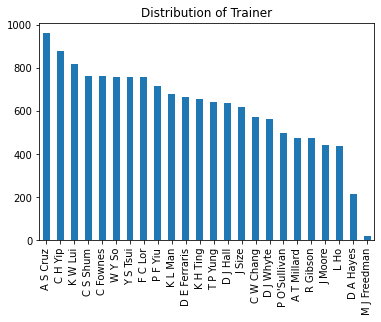

In [ ]:
horse_info_processed1["Trainer"].value_counts().plot(kind="bar",title="Distribution of Trainer")

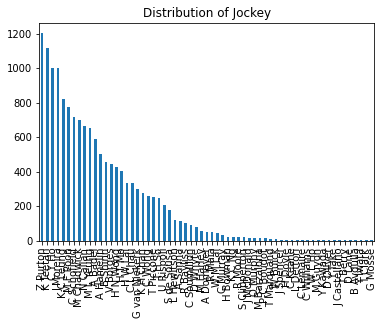

In [ ]:
horse_info_processed1["Jockey"].value_counts().plot(kind="bar",title="Distribution of Jockey")

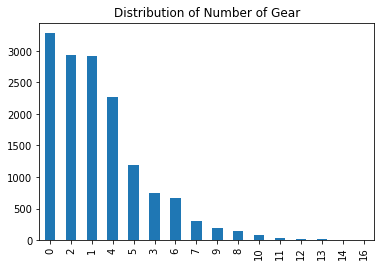

In [ ]:
horse_info_processed1["NoofGear"].value_counts().plot(kind="bar",title="Distribution of Number of Gear")

 Turf     13380
 AWT       1411
 Turf         2
 Sand         1
Name: Track, dtype: int64

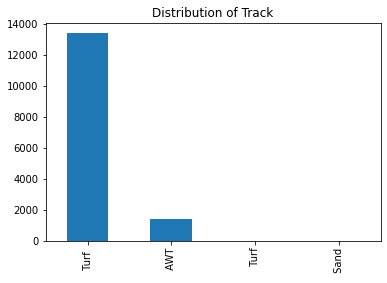

In [ ]:
horse_info_processed1["Track"].value_counts().plot(kind="bar",title="Distribution of Track")
horse_info_processed1["Track"].value_counts()

G     9568
GF    3521
GD    1180
WS     231
GY     194
Y       99
MY       1
Name: G, dtype: int64

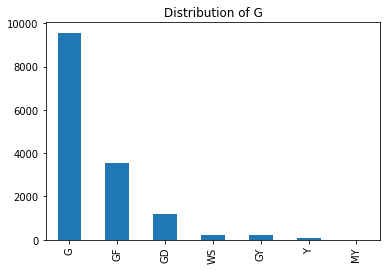

In [ ]:
horse_info_processed1["G"].value_counts().plot(kind="bar",title="Distribution of G")
horse_info_processed1["G"].value_counts()

ST         9451
HV         5328
CH           12
Kranji        2
Seoul         1
Name: RC, dtype: int64

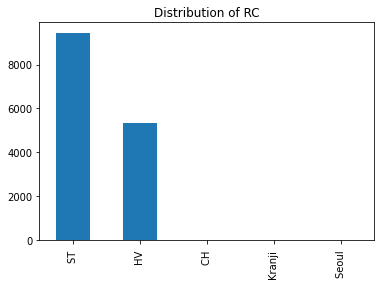

In [ ]:
horse_info_processed1["RC"].value_counts().plot(kind="bar",title="Distribution of RC")
horse_info_processed1["RC"].value_counts()

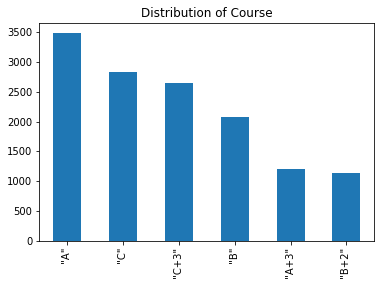

In [ ]:
horse_info_processed1["Course"].value_counts().plot(kind="bar",title="Distribution of Course")

4          6168
3          5250
2          1363
5          1327
1           156
G3          134
G1          133
4YO          88
G2           81
GRIFFIN      52
4R           30
R             9
SIN G1        2
KOR G1        1
Name: RaceClass, dtype: int64

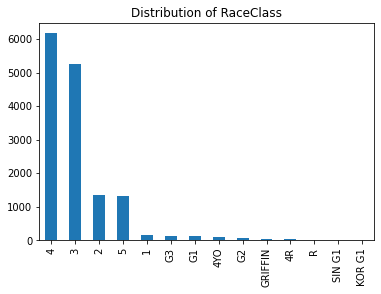

In [ ]:
horse_info_processed1["RaceClass"].value_counts().plot(kind="bar",title="Distribution of RaceClass")
horse_info_processed1["RaceClass"].value_counts()

The following preprocess will be carried out:

1. ['G','RaceClass','RC','Track','Course']: one hot encoding
2. ['Trainer','Jockey']: drop
3. remove data row which contains special entries in the above columns, e.g {Kranji, Seoul} in 'RC', {'MY'} in 'G', {Turf, Sand} in 'Track',{'SIN G1','KOR G1','R'} in RaceClass

In [ ]:
horse_info_processed1[horse_info_processed1.RC.str.contains('Kranji|Seoul')]

,Pla.,Dist.,G,RaceClass,Dr.,Rtg.,Trainer,Jockey,Win Odds,Act.Wt.,Finish Time,Declar.Horse Wt.,Gear,horse,season,N_RaceIndex,RC,Track,Course,NoofGear
4837,4,1800,MY,KOR G1,1,94.0,F C Lor,C Y Ho,3.3,126,11450,NaN,NaN,2017_B210,19/20,19/20_Overseas,Seoul,Sand,None,0
10981,3,1600,G,SIN G1,10,118.0,A T Millard,K Teetan,3.8,126,9411,NaN,SR/XB,2017_B104,18/19,18/19_Overseas,Kranji,Turf,None,5
11445,1,1600,G,SIN G1,2,123.0,C Fownes,Z Purton,1.6,126,9361,NaN,XB-/V2,2016_A252,18/19,18/19_Overseas,Kranji,Turf,None,6


In [ ]:
horse_info_processed1[horse_info_processed1['RaceClass']=='R']

,Pla.,Dist.,G,RaceClass,Dr.,Rtg.,Trainer,Jockey,Win Odds,Act.Wt.,Finish Time,Declar.Horse Wt.,Gear,horse,season,N_RaceIndex,RC,Track,Course,NoofGear
7355,4,1400,G,R,3,49.0,C H Yip,A Badel,26.0,120,8324,1087.0,TT,2018_C419,19/20,19/20_284,ST,Turf,"""B+2""",2
7386,2,1400,G,R,4,51.0,K L Man,S de Sousa,11.0,120,8287,1078.0,NaN,2018_C437,19/20,19/20_284,ST,Turf,"""B+2""",0
8012,6,1400,G,R,7,54.0,C Fownes,C Y Ho,3.9,120,8359,1090.0,NaN,2019_D050,19/20,19/20_284,ST,Turf,"""B+2""",0
8846,3,1400,G,R,1,52.0,C H Yip,D Whyte,129.0,120,8293,1046.0,NaN,2017_B426,18/19,18/19_275,ST,Turf,"""A+3""",0
9086,1,1200,G,R,2,64.0,R Gibson,M Chadwick,NaN,122,6928,1068.0,H-/B,2017_B371,18/19,18/19_515,CH,Turf,"""A""",4
9089,6,1400,G,R,8,62.0,R Gibson,M Chadwick,11.0,122,8307,1087.0,B/H,2017_B371,18/19,18/19_275,ST,Turf,"""A+3""",3
9879,2,1400,G,R,5,53.0,D J Hall,C Schofield,24.0,120,8287,1071.0,NaN,2017_B250,18/19,18/19_275,ST,Turf,"""A+3""",0
10777,8,1400,G,R,2,56.0,R Gibson,A Badel,20.0,120,8400,1078.0,NaN,2018_C046,18/19,18/19_275,ST,Turf,"""A+3""",0
11131,2,1200,G,R,4,63.0,W Y So,A Sanna,NaN,125,6946,1155.0,B/TT,2016_A314,18/19,18/19_515,CH,Turf,"""A""",4


In [ ]:
#final preprocess on horse_info
def horse_info_final_preprocess(df):
    df=df[~df.RC.str.contains('Kranji|Seoul')]
    df=df[df.RaceClass!='R']
    df=pd.get_dummies(df,columns=['G','RaceClass','RC','Track','Course'])
    df.drop(["Trainer", "Jockey"], axis=1, inplace=True)

    return df

In [ ]:
horse_info_final=horse_info_final_preprocess(horse_info_processed1)

In [ ]:
horse_info_final

,Pla.,Dist.,Dr.,Rtg.,Win Odds,Act.Wt.,Finish Time,Declar.Horse Wt.,Gear,horse,N_RaceIndex,NoofGear,G_G,G_GD,G_GF,G_GY,G_WS,G_Y,RaceClass_1,RaceClass_2,RaceClass_3,RaceClass_4,RaceClass_4R,RaceClass_4YO,RaceClass_5,RaceClass_G1,RaceClass_G2,RaceClass_G3,RaceClass_GRIFFIN,RC_CH,RC_HV,RC_ST,Track_ AWT,Track_ Turf,"Course_ ""A""","Course_ ""A+3""","Course_ ""B""","Course_ ""B+2""","Course_ ""C""","Course_ ""C+3"""
0,11,1650,10,60.0,150.0,130,10271,1217.0,B/TT-,2019_D466,20/21_452,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1,14,1600,14,64.0,396.0,112,9764,1222.0,B1/TT,2019_D466,20/21_334,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
2,12,1400,9,67.0,346.0,118,8318,1238.0,TT1,2019_D466,20/21_263,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0
3,14,1400,7,70.0,320.0,115,8299,1253.0,NaN,2019_D466,20/21_192,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
4,12,1400,9,72.0,163.0,125,8302,1223.0,NaN,2019_D466,20/21_120,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15012,13,1200,7,72.0,252.0,125,7045,1060.0,H1/TT1,2017_B406,18/19_117,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0
15013,3,1400,7,59.0,4.8,132,8162,1031.0,H/P/TT,2019_D415,20/21_542,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0
15014,1,1400,2,53.0,5.3,128,8213,1028.0,H/P/TT,2019_D415,20/21_463,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
15015,6,1400,9,53.0,13.0,127,8253,1042.0,H/P/TT,2019_D415,20/21_390,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0


## Load horse_family

In [ ]:
horse_family = pd.read_csv("drive/MyDrive/COMP3359 Project/horse_family.csv")

In [ ]:
horse_family.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             1293 non-null   int64  
 1   Import Type                            1293 non-null   object 
 2   Season Stakes*                         1293 non-null   object 
 3   Total Stakes*                          1293 non-null   object 
 4   No. of 1-2-3-Starts*                   1293 non-null   object 
 5   No. of starts in past 10race meetings  1293 non-null   int64  
 6   PP Pre-import races footage            0 non-null      float64
 7   Current Stable Location(Arrival Date)  1293 non-null   object 
 8   Trainer                                1293 non-null   object 
 9   Owner                                  1293 non-null   object 
 10  Current Rating                         1234 non-null   float64
 11  Star

In [ ]:
horse_family.head()

,Unnamed: 0,Import Type,Season Stakes*,Total Stakes*,No. of 1-2-3-Starts*,No. of starts in past 10race meetings,PP Pre-import races footage,Current Stable Location(Arrival Date),Trainer,Owner,Current Rating,Start ofSeason Rating,Sire,Dam,Dam's Sire,Same Sire,Country of Origin,Age,Colour,Sex,name
0,0,PP,$0,$0,0-0-0-6,0,NaN,Hong Kong(08/06/2020),L Ho,Focuson Syndicate,60.0,72.0,O'Reilly,Music,Pins,BRIGHT VISION GOKO NUNCHUKS SACRED IBIS SHININ...,NZ,5,Bay,Gelding,2019_D466
1,1,PPG,"$570,000","$570,000",1-0-0-2,1,NaN,Conghua(25/03/2021),K H Ting,Nadine Lai,60.0,52.0,Denman,Red Magnum,Domesday,E416 CHAMPION SUPREME DR PROACTIVE GOLDEN FOUR...,AUS,3,Bay,Gelding,2020_E147
2,2,PPG,"$290,000","$290,000",0-1-0-5,0,NaN,Conghua(08/02/2021),J Size,Vicky Tang,50.0,52.0,Per Incanto,Diamond Start,Lonhro,E418 CHARITY GRACE CLASSIC UNICORN DAZZLING FE...,NZ,4,Bay,Gelding,2020_E089
3,3,PP,$0,$0,0-0-0-0,0,NaN,Conghua(04/03/2021),D A Hayes,"Charmaine Li Chi Yin, Adrian Li Kwok Sheung & ...",75.0,75.0,Dream Ahead,Maxi Dress,Shamardal,DIONYSUS COLLIN FABULOUS EIGHT SKY SPRINTER SU...,AUS,3,Bay,Gelding,2020_E202
4,4,PPG,"$1,270,000","$4,000,540",5-3-3-32,2,NaN,Hong Kong(23/07/2020),A T Millard,Mr & Mrs Paul Kan Man Lok,67.0,65.0,Tavistock,Once More,Thorn Park,BELUGA BUNDLE OF DELIGHT CELESTIAL VINTAGE CIN...,NZ,5,Bay,Gelding,2017_B345


### Chart

In [ ]:
for i in horse_family.columns:
  try:
    print("------------",i,"------------")
    print(horse_family[i].describe())
  except:
    continue

------------ Unnamed: 0 ------------
count    1293.000000
mean      646.000000
std       373.401259
min         0.000000
25%       323.000000
50%       646.000000
75%       969.000000
max      1292.000000
Name: Unnamed: 0, dtype: float64
------------ Import Type ------------
count     1293
unique       3
top        PPG
freq       713
Name: Import Type, dtype: object
------------ Season Stakes* ------------
count     1293
unique     438
top         $0
freq       512
Name: Season Stakes*, dtype: object
------------ Total Stakes* ------------
count     1293
unique     732
top         $0
freq       435
Name: Total Stakes*, dtype: object
------------ No. of 1-2-3-Starts* ------------
count        1293
unique        666
top       0-0-0-0
freq          223
Name: No. of 1-2-3-Starts*, dtype: object
------------ No. of starts in past 10race meetings ------------
count    1293.000000
mean        0.887858
std         0.824705
min         0.000000
25%         0.000000
50%         1.000000
75%     

PPG    713
PP     508
ISG     72
Name: Import Type, dtype: int64

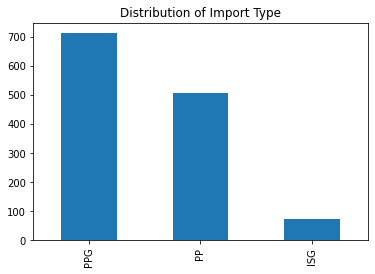

In [ ]:
horse_family["Import Type"].value_counts().plot(kind="bar",title="Distribution of Import Type")
horse_family["Import Type"].value_counts()

AUS     646
NZ      330
IRE     156
GB       67
SAF      33
FR       25
USA      15
GER       7
JPN       4
BRZ       4
CHI       2
ARG       2
ITY       2
Name: Country of Origin, dtype: int64

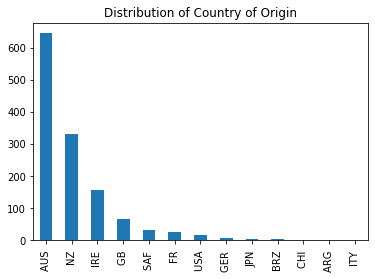

In [ ]:
horse_family["Country of Origin"].value_counts().plot(kind="bar",title="Distribution of Country of Origin")
horse_family["Country of Origin"].value_counts()

Bay          850
Chestnut     210
Brown        169
Grey          50
Dark Bay       9
Black          5
Name: Colour, dtype: int64

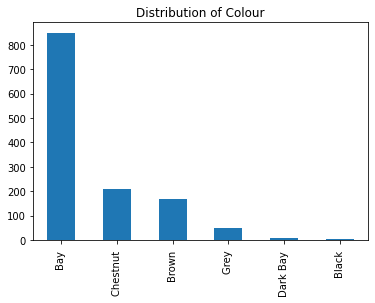

In [ ]:
horse_family["Colour"].value_counts().plot(kind="bar",title="Distribution of Colour")
horse_family["Colour"].value_counts()

 Gelding    1219
 Colt         32
 Brown        27
 Grey          5
 Horse         4
 Rig           3
 Roan          2
 Filly         1
Name: Sex, dtype: int64

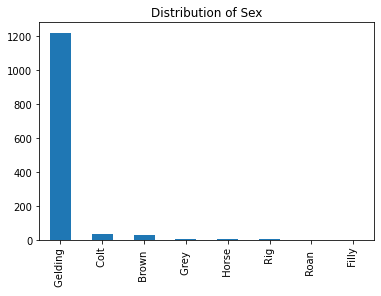

In [ ]:
horse_family["Sex"].value_counts().plot(kind="bar",title="Distribution of Sex")
horse_family["Sex"].value_counts()

In [ ]:
horse_family["Dam"].value_counts()

Savabeel Star         3
Extension Of Time     3
Princess Annaliese    2
Steps In Time         2
Diademe               2
                     ..
Negotiate             1
Queen Of Quilts       1
Anne Of Cleves        1
Princess Paris        1
Angelic Air           1
Name: Dam, Length: 1261, dtype: int64

In [ ]:
horse_family["No. of starts in past 10race meetings"].value_counts()

0    497
1    467
2    306
3     23
Name: No. of starts in past 10race meetings, dtype: int64

["Import Type", "Current Stable Location", "Trainer","Owner","Same Sire"," PP Pre-import races footage","Start of Season Rating" ]: drop

In [ ]:
def horse_family_preprocess(df):
    try:
        df.drop(["Unnamed: 0", "PP Pre-import races footage", "Current Stable Location(Arrival Date)", "Owner", "Same Sire", "Current Rating", "Start ofSeason Rating", "Trainer"], axis=1, inplace=True)
    except:
        pass    

    df[['First','Second','Third','Total']] = df['No. of 1-2-3-Starts*'].str.split('-', expand=True)
    df["top 3%"]=(df["First"].astype(int)+df["Second"].astype(int)+df["Third"].astype(int))/df["Total"].astype(int)
    df["top 3%"] = df["top 3%"].fillna(0)

    df["Season Stakes*"] = df["Season Stakes*"].str.split("$", expand=True)[1]
    df["Season Stakes*"] = df["Season Stakes*"].replace(',','', regex=True)
    df["Season Stakes*"] = df["Season Stakes*"].astype(float)

    df["Total Stakes*"] = df["Total Stakes*"].str.split("$", expand=True)[1]
    df["Total Stakes*"] = df["Total Stakes*"].replace(',','', regex=True)
    df["Total Stakes*"] = df["Total Stakes*"].astype(float)

    return df

In [ ]:
horse_family_processed1=horse_family_preprocess(horse_family)
horse_family_processed1

,Import Type,Season Stakes*,Total Stakes*,No. of 1-2-3-Starts*,No. of starts in past 10race meetings,Sire,Dam,Dam's Sire,Country of Origin,Age,Colour,Sex,name,First,Second,Third,Total,top 3%
0,PP,0.0,0.0,0-0-0-6,0,O'Reilly,Music,Pins,NZ,5,Bay,Gelding,2019_D466,0,0,0,6,0.000000
1,PPG,570000.0,570000.0,1-0-0-2,1,Denman,Red Magnum,Domesday,AUS,3,Bay,Gelding,2020_E147,1,0,0,2,0.500000
2,PPG,290000.0,290000.0,0-1-0-5,0,Per Incanto,Diamond Start,Lonhro,NZ,4,Bay,Gelding,2020_E089,0,1,0,5,0.200000
3,PP,0.0,0.0,0-0-0-0,0,Dream Ahead,Maxi Dress,Shamardal,AUS,3,Bay,Gelding,2020_E202,0,0,0,0,0.000000
4,PPG,1270000.0,4000540.0,5-3-3-32,2,Tavistock,Once More,Thorn Park,NZ,5,Bay,Gelding,2017_B345,5,3,3,32,0.343750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,PPG,0.0,0.0,0-0-0-0,0,Teofilo,Yes Oh Yes,Gone West,IRE,4,Bay,Gelding,2019_D462,0,0,0,0,0.000000
1289,PPG,35000.0,35000.0,0-0-0-5,3,Albrecht,Snaffles,Librettist,AUS,4,Bay,Gelding,2020_E078,0,0,0,5,0.000000
1290,PPG,0.0,0.0,0-0-0-1,1,The Factor,Dollars Not Sense,Onemorenomore,AUS,3,Grey,Gelding,2020_E186,0,0,0,1,0.000000
1291,PP,650000.0,2307935.0,1-4-3-29,1,Big Bad Bob,Rupa,Acclamation,IRE,6,Brown,Gelding,2017_B406,1,4,3,29,0.275862


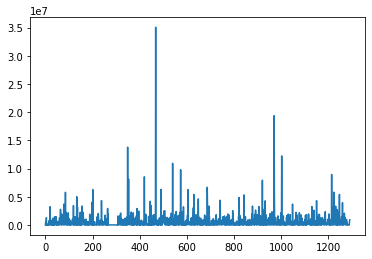

In [ ]:
horse_family_processed1["Season Stakes*"].plot()

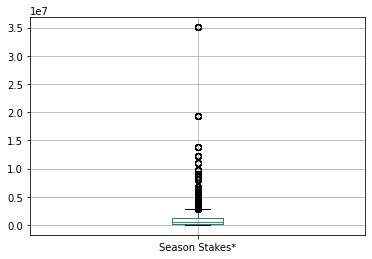

In [ ]:
figure=horse_family_processed1.boxplot(column="Season Stakes*")

In [ ]:
horse_family_processed1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Import Type                            1293 non-null   object 
 1   Season Stakes*                         1293 non-null   float64
 2   Total Stakes*                          1293 non-null   float64
 3   No. of 1-2-3-Starts*                   1293 non-null   object 
 4   No. of starts in past 10race meetings  1293 non-null   int64  
 5   Sire                                   1293 non-null   object 
 6   Dam                                    1293 non-null   object 
 7   Dam's Sire                             1293 non-null   object 
 8   Country of Origin                      1293 non-null   object 
 9   Age                                    1293 non-null   int64  
 10  Colour                                 1293 non-null   object 
 11  Sex 

In [ ]:
#final preprocess on horse_info
def horse_family_final_preprocess(df):
    df.drop(["Import Type","Total Stakes*","No. of 1-2-3-Starts*","No. of starts in past 10race meetings","Sire","Dam","Dam's Sire","First","Second","Third","Total","top 3%"], axis=1, inplace=True)
    df=pd.get_dummies(df,columns=['Country of Origin','Colour','Sex'])
    return df

In [ ]:
horse_family_final=horse_family_final_preprocess(horse_family_processed1)

In [ ]:
horse_family_final

,Season Stakes*,Age,name,Country of Origin_ARG,Country of Origin_AUS,Country of Origin_BRZ,Country of Origin_CHI,Country of Origin_FR,Country of Origin_GB,Country of Origin_GER,Country of Origin_IRE,Country of Origin_ITY,Country of Origin_JPN,Country of Origin_NZ,Country of Origin_SAF,Country of Origin_USA,Colour_Bay,Colour_Black,Colour_Brown,Colour_Chestnut,Colour_Dark Bay,Colour_Grey,Sex_ Brown,Sex_ Colt,Sex_ Filly,Sex_ Gelding,Sex_ Grey,Sex_ Horse,Sex_ Rig,Sex_ Roan
0,0.0,5,2019_D466,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,570000.0,3,2020_E147,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,290000.0,4,2020_E089,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.0,3,2020_E202,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1270000.0,5,2017_B345,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,0.0,4,2019_D462,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1289,35000.0,4,2020_E078,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1290,0.0,3,2020_E186,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1291,650000.0,6,2017_B406,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


## Merge two tables

In [ ]:
merged_table = pd.merge(horse_info_final, horse_family_final, how="inner", left_on="horse", right_on="name")
merged_table.drop(["name"], axis=1, inplace=True)

In [ ]:
merged_table

,Pla.,Dist.,Dr.,Rtg.,Win Odds,Act.Wt.,Finish Time,Declar.Horse Wt.,Gear,horse,N_RaceIndex,NoofGear,G_G,G_GD,G_GF,G_GY,G_WS,G_Y,RaceClass_1,RaceClass_2,RaceClass_3,RaceClass_4,RaceClass_4R,RaceClass_4YO,RaceClass_5,RaceClass_G1,RaceClass_G2,RaceClass_G3,RaceClass_GRIFFIN,RC_CH,RC_HV,RC_ST,Track_ AWT,Track_ Turf,"Course_ ""A""","Course_ ""A+3""","Course_ ""B""","Course_ ""B+2""","Course_ ""C""","Course_ ""C+3""",Season Stakes*,Age,Country of Origin_ARG,Country of Origin_AUS,Country of Origin_BRZ,Country of Origin_CHI,Country of Origin_FR,Country of Origin_GB,Country of Origin_GER,Country of Origin_IRE,Country of Origin_ITY,Country of Origin_JPN,Country of Origin_NZ,Country of Origin_SAF,Country of Origin_USA,Colour_Bay,Colour_Black,Colour_Brown,Colour_Chestnut,Colour_Dark Bay,Colour_Grey,Sex_ Brown,Sex_ Colt,Sex_ Filly,Sex_ Gelding,Sex_ Grey,Sex_ Horse,Sex_ Rig,Sex_ Roan
0,11,1650,10,60.0,150.0,130,10271,1217.0,B/TT-,2019_D466,20/21_452,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,14,1600,14,64.0,396.0,112,9764,1222.0,B1/TT,2019_D466,20/21_334,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,12,1400,9,67.0,346.0,118,8318,1238.0,TT1,2019_D466,20/21_263,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,14,1400,7,70.0,320.0,115,8299,1253.0,NaN,2019_D466,20/21_192,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,12,1400,9,72.0,163.0,125,8302,1223.0,NaN,2019_D466,20/21_120,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14682,13,1200,7,72.0,252.0,125,7045,1060.0,H1/TT1,2017_B406,18/19_117,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,650000.0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
14683,3,1400,7,59.0,4.8,132,8162,1031.0,H/P/TT,2019_D415,20/21_542,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14684,1,1400,2,53.0,5.3,128,8213,1028.0,H/P/TT,2019_D415,20/21_463,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14685,6,1400,9,53.0,13.0,127,8253,1042.0,H/P/TT,2019_D415,20/21_390,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


fill in the na value on age:

In [ ]:
merged_table.isnull().sum()

Pla.             0
Dist.            0
Dr.              0
Rtg.            53
Win Odds        10
                ..
Sex_ Gelding     0
Sex_ Grey        0
Sex_ Horse       0
Sex_ Rig         0
Sex_ Roan        0
Length: 69, dtype: int64

In [ ]:
#impute the rating and remove data without win odds
def merge_table_preprocessing(df):
  df = df[df['Win Odds'].notna()]
  df.drop(['Gear'], axis=1, inplace=True)
  for ind in df.index:
  #if rtg. is missing
    if (pd.isnull(df.loc[ind,'Rtg.'])==True):
      #if northern
      if (df['Country of Origin_GB '][ind]==1 or df['Country of Origin_IRE '][ind]==1 or df['Country of Origin_FR '][ind]==1 or df['Country of Origin_USA '][ind]==1 or df['Country of Origin_GER '][ind]==1 or df['Country of Origin_JPN '][ind]==1 or df['Country of Origin_ITY '][ind]==1):
        try:
          df['Rtg.'][ind]=57
        except:
          continue
      else:
        df['Rtg.'][ind]=52
  return df

In [ ]:
merged_final = merge_table_preprocessing(merged_table)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back

In [ ]:
merged_final

,Pla.,Dist.,Dr.,Rtg.,Win Odds,Act.Wt.,Finish Time,Declar.Horse Wt.,horse,N_RaceIndex,NoofGear,G_G,G_GD,G_GF,G_GY,G_WS,G_Y,RaceClass_1,RaceClass_2,RaceClass_3,RaceClass_4,RaceClass_4R,RaceClass_4YO,RaceClass_5,RaceClass_G1,RaceClass_G2,RaceClass_G3,RaceClass_GRIFFIN,RC_CH,RC_HV,RC_ST,Track_ AWT,Track_ Turf,"Course_ ""A""","Course_ ""A+3""","Course_ ""B""","Course_ ""B+2""","Course_ ""C""","Course_ ""C+3""",Season Stakes*,Age,Country of Origin_ARG,Country of Origin_AUS,Country of Origin_BRZ,Country of Origin_CHI,Country of Origin_FR,Country of Origin_GB,Country of Origin_GER,Country of Origin_IRE,Country of Origin_ITY,Country of Origin_JPN,Country of Origin_NZ,Country of Origin_SAF,Country of Origin_USA,Colour_Bay,Colour_Black,Colour_Brown,Colour_Chestnut,Colour_Dark Bay,Colour_Grey,Sex_ Brown,Sex_ Colt,Sex_ Filly,Sex_ Gelding,Sex_ Grey,Sex_ Horse,Sex_ Rig,Sex_ Roan
0,11,1650,10,60.0,150.0,130,10271,1217.0,2019_D466,20/21_452,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,14,1600,14,64.0,396.0,112,9764,1222.0,2019_D466,20/21_334,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,12,1400,9,67.0,346.0,118,8318,1238.0,2019_D466,20/21_263,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,14,1400,7,70.0,320.0,115,8299,1253.0,2019_D466,20/21_192,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,12,1400,9,72.0,163.0,125,8302,1223.0,2019_D466,20/21_120,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14682,13,1200,7,72.0,252.0,125,7045,1060.0,2017_B406,18/19_117,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,650000.0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
14683,3,1400,7,59.0,4.8,132,8162,1031.0,2019_D415,20/21_542,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14684,1,1400,2,53.0,5.3,128,8213,1028.0,2019_D415,20/21_463,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14685,6,1400,9,53.0,13.0,127,8253,1042.0,2019_D415,20/21_390,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


## Data Exploration and Normalization

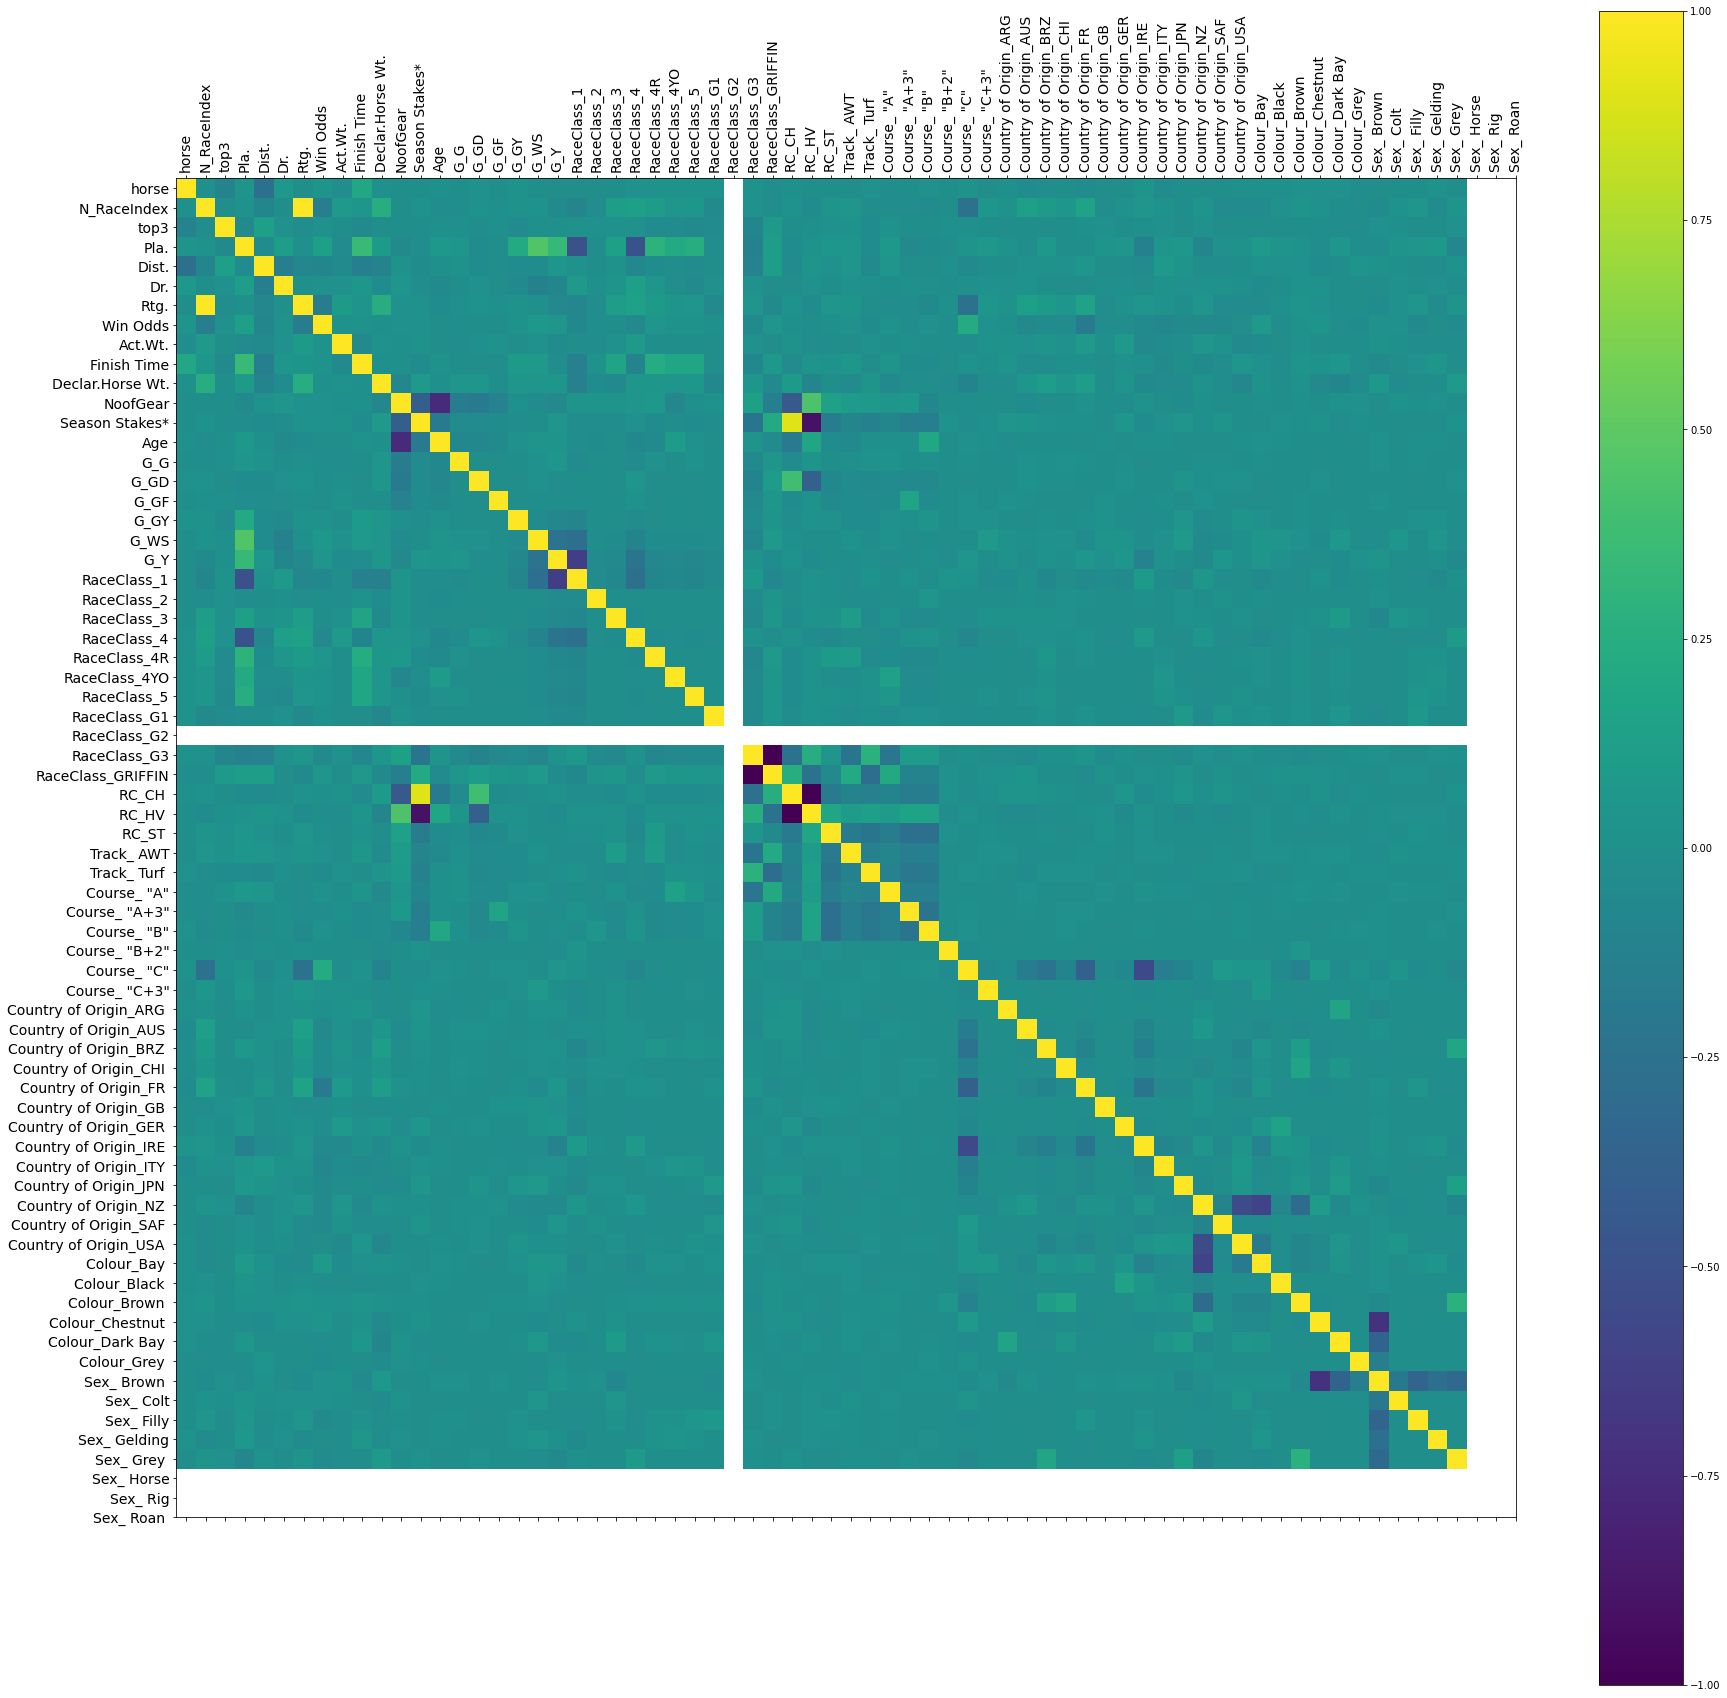

In [ ]:
import matplotlib.pyplot as plt

df=fdf

def phase_corrmat():
  f = plt.figure(figsize=(30,30))
  #df = test_df
  plt.matshow(df.corr(), fignum=f.number)
  plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
  plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
  plt.colorbar()
phase_corrmat()

In [ ]:
merged_final.columns

Index(['Pla.', 'Dist.', 'Dr.', 'Rtg.', 'Win Odds', 'Act.Wt.', 'Finish Time',
       'Declar.Horse Wt.', 'horse', 'N_RaceIndex', 'NoofGear', 'G_G', 'G_GD',
       'G_GF', 'G_GY', 'G_WS', 'G_Y', 'RaceClass_1', 'RaceClass_2',
       'RaceClass_3', 'RaceClass_4', 'RaceClass_4R', 'RaceClass_4YO',
       'RaceClass_5', 'RaceClass_G1', 'RaceClass_G2', 'RaceClass_G3',
       'RaceClass_GRIFFIN', 'RC_CH ', 'RC_HV ', 'RC_ST ', 'Track_ AWT',
       'Track_ Turf ', 'Course_ "A"', 'Course_ "A+3"', 'Course_ "B"',
       'Course_ "B+2"', 'Course_ "C"', 'Course_ "C+3"', 'Season Stakes*',
       'Age', 'Country of Origin_ARG ', 'Country of Origin_AUS ',
       'Country of Origin_BRZ ', 'Country of Origin_CHI ',
       'Country of Origin_FR ', 'Country of Origin_GB ',
       'Country of Origin_GER ', 'Country of Origin_IRE ',
       'Country of Origin_ITY ', 'Country of Origin_JPN ',
       'Country of Origin_NZ ', 'Country of Origin_SAF ',
       'Country of Origin_USA ', 'Colour_Bay ', 'Colour_Black '

In [ ]:
fdf=merged_final

def top_3(row):
  if int(row['Pla.'])<=3:
    return 1
  else:
    return 0

def top_1(row):
  if int(row['Pla.'])==1: return 1
  return 0

fdf['top3'] = fdf.apply(top_3, axis=1)
fdf['top1'] = fdf.apply(top_1, axis=1)

fdf=fdf[['horse','N_RaceIndex','top3','top1','Pla.','Finish Time','Dist.','Dr.','Rtg.','Win Odds', 'Act.Wt.',
       'Declar.Horse Wt.', 'NoofGear','Season Stakes*',
       'Age','G_G', 'G_GD','G_GF', 'G_GY', 'G_WS', 'G_Y', 'RaceClass_1', 'RaceClass_2',
       'RaceClass_3', 'RaceClass_4', 'RaceClass_4R', 'RaceClass_4YO',
       'RaceClass_5', 'RaceClass_G1', 'RaceClass_G2', 'RaceClass_G3',
       'RaceClass_GRIFFIN', 'RC_CH ', 'RC_HV ', 'RC_ST ', 'Track_ AWT',
       'Track_ Turf ', 'Course_ "A"', 'Course_ "A+3"', 'Course_ "B"',
       'Course_ "B+2"', 'Course_ "C"', 'Course_ "C+3"', 'Country of Origin_ARG ', 'Country of Origin_AUS ',
       'Country of Origin_BRZ ', 'Country of Origin_CHI ',
       'Country of Origin_FR ', 'Country of Origin_GB ',
       'Country of Origin_GER ', 'Country of Origin_IRE ',
       'Country of Origin_ITY ', 'Country of Origin_JPN ',
       'Country of Origin_NZ ', 'Country of Origin_SAF ',
       'Country of Origin_USA ', 'Colour_Bay ', 'Colour_Black ',
       'Colour_Brown ', 'Colour_Chestnut ', 'Colour_Dark Bay ', 'Colour_Grey ',
       'Sex_ Brown ', 'Sex_ Colt', 'Sex_ Filly', 'Sex_ Gelding', 'Sex_ Grey ',
       'Sex_ Horse', 'Sex_ Rig', 'Sex_ Roan ']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
fdf

,horse,N_RaceIndex,top3,top1,Pla.,Finish Time,Dist.,Dr.,Rtg.,Win Odds,Act.Wt.,Declar.Horse Wt.,NoofGear,Season Stakes*,Age,G_G,G_GD,G_GF,G_GY,G_WS,G_Y,RaceClass_1,RaceClass_2,RaceClass_3,RaceClass_4,RaceClass_4R,RaceClass_4YO,RaceClass_5,RaceClass_G1,RaceClass_G2,RaceClass_G3,RaceClass_GRIFFIN,RC_CH,RC_HV,RC_ST,Track_ AWT,Track_ Turf,"Course_ ""A""","Course_ ""A+3""","Course_ ""B""","Course_ ""B+2""","Course_ ""C""","Course_ ""C+3""",Country of Origin_ARG,Country of Origin_AUS,Country of Origin_BRZ,Country of Origin_CHI,Country of Origin_FR,Country of Origin_GB,Country of Origin_GER,Country of Origin_IRE,Country of Origin_ITY,Country of Origin_JPN,Country of Origin_NZ,Country of Origin_SAF,Country of Origin_USA,Colour_Bay,Colour_Black,Colour_Brown,Colour_Chestnut,Colour_Dark Bay,Colour_Grey,Sex_ Brown,Sex_ Colt,Sex_ Filly,Sex_ Gelding,Sex_ Grey,Sex_ Horse,Sex_ Rig,Sex_ Roan
0,2019_D466,20/21_452,0,0,11,10271,1650,10,60.0,150.0,130,1217.0,5,0.0,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2019_D466,20/21_334,0,0,14,9764,1600,14,64.0,396.0,112,1222.0,5,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2019_D466,20/21_263,0,0,12,8318,1400,9,67.0,346.0,118,1238.0,3,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2019_D466,20/21_192,0,0,14,8299,1400,7,70.0,320.0,115,1253.0,0,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2019_D466,20/21_120,0,0,12,8302,1400,9,72.0,163.0,125,1223.0,0,0.0,5,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14682,2017_B406,18/19_117,0,0,13,7045,1200,7,72.0,252.0,125,1060.0,6,650000.0,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
14683,2019_D415,20/21_542,1,0,3,8162,1400,7,59.0,4.8,132,1031.0,6,905000.0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14684,2019_D415,20/21_463,1,1,1,8213,1400,2,53.0,5.3,128,1028.0,6,905000.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14685,2019_D415,20/21_390,0,0,6,8253,1400,9,53.0,13.0,127,1042.0,6,905000.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
from google.colab import files
fdf.to_csv("full_data.csv", index=False)
files.download("full_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
### Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')
### Load data from drive
fdf = pd.read_csv("drive/MyDrive/COMP3359 Project/full_data.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train, df_test = train_test_split(fdf,test_size=0.2)

pos_train = df_train["Pla."]
x_train = df_train.iloc[:,6:].values
y3_train = df_train["top3"]
y1_train = df_train["top1"]

pos_test = df_test["Pla."]
x_test = df_test.iloc[:,6:].values
y3_test = df_test["top3"]
y1_test = df_test["top1"]

feature=df_train.columns[6:].values

# Model (Go to here directly)
<a id="model"></a>

In [ ]:
# import the necessnary libs
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
import urllib
from google.colab import drive
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

In [2]:
### Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Random Forest

### 1. naive model

A naive random forest model, with all the features included

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(x_train, y1_train)
y1_pred=rf_clf.predict(x_test)
print('Accuracy for top 1:', accuracy_score(y1_test, y1_pred).round(4))

rf_clf.fit(x_train, y3_train)
y3_pred=rf_clf.predict(x_test)
print('Accuracy for top 3:', accuracy_score(y3_test, y3_pred).round(4))

Accuracy for top 1: 0.9057
Accuracy for top 3: 0.7534


### 2. Model consider variable importance: classifier on 'top3'

In [ ]:
#pip install eli5import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# define a permutation importance object
perm = PermutationImportance(rf_clf).fit(x_train, y3_train)
# show the importance
eli5.show_weights(perm, feature_names=feature)

Weight,Feature
0.1980 ± 0.0053,Win Odds
0.0935 ± 0.0034,Season Stakes*
0.0574 ± 0.0031,Dr.
0.0387 ± 0.0023,Declar.Horse Wt.
0.0336 ± 0.0025,Act.Wt.
0.0212 ± 0.0020,Rtg.
0.0158 ± 0.0009,Age
0.0150 ± 0.0018,Dist.
0.0144 ± 0.0012,NoofGear
0.0035 ± 0.0004,Country of Origin_AUS


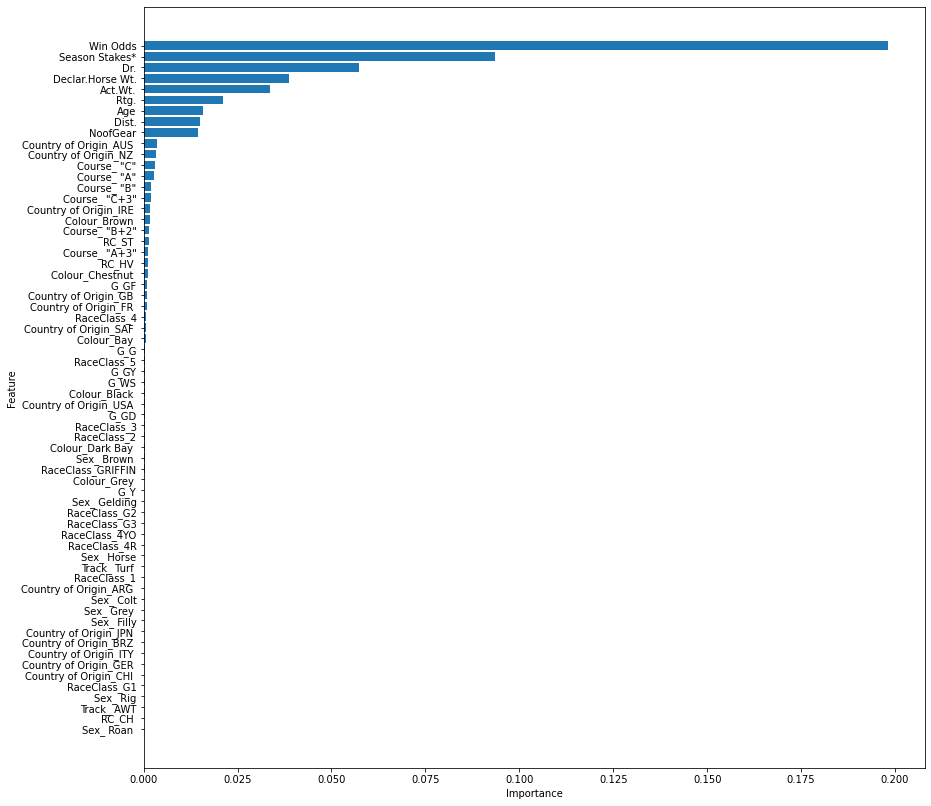

In [ ]:
# importance in decreasing order
imp_ord = np.argsort(perm.feature_importances_)

plt.figure(figsize=(14,14))
yaxis = np.arange(len(perm.feature_importances_))*1
plt.barh(y = yaxis,width = perm.feature_importances_[imp_ord])
plt.yticks(yaxis,feature[imp_ord])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

In [ ]:
importance_table=pd.DataFrame({'features':feature[imp_ord],'importance':perm.feature_importances_[imp_ord]})
print(importance_table.to_string())

                  features  importance
0               Sex_ Roan     0.000000
1                   RC_CH     0.000000
2               Track_ AWT    0.000000
3                 Sex_ Rig    0.000000
4             RaceClass_G1    0.000000
5   Country of Origin_CHI     0.000000
6   Country of Origin_GER     0.000000
7   Country of Origin_ITY     0.000000
8   Country of Origin_BRZ     0.000000
9   Country of Origin_JPN     0.000000
10              Sex_ Filly    0.000000
11              Sex_ Grey     0.000000
12               Sex_ Colt    0.000085
13  Country of Origin_ARG     0.000085
14             RaceClass_1    0.000085
15            Track_ Turf     0.000085
16              Sex_ Horse    0.000085
17            RaceClass_4R    0.000085
18           RaceClass_4YO    0.000085
19            RaceClass_G3    0.000085
20            RaceClass_G2    0.000085
21            Sex_ Gelding    0.000170
22                     G_Y    0.000170
23            Colour_Grey     0.000170
24       RaceClass_GRIFFI

In [ ]:
#we select the features with importance > 0.01
selected=importance_table[importance_table['importance']>0.01]["features"]
selected

55            NoofGear
56               Dist.
57                 Age
58                Rtg.
59             Act.Wt.
60    Declar.Horse Wt.
61                 Dr.
62      Season Stakes*
63            Win Odds
Name: features, dtype: object

In [ ]:
df_train, df_test = train_test_split(fdf,test_size=0.2)

pos_train = df_train["Pla."]
x_train = df_train.iloc[:,6:].values
sx_train = df_train[selected].values
y3_train = df_train["top3"]
y1_train = df_train["top1"]

pos_test = df_test["Pla."]
x_test = df_test.iloc[:,6:].values
y3_test = df_test["top3"]
y1_test = df_test["top1"]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(sx_train, y3_train)
y3_pred=rf_clf.predict(sx_test)
print('Accuracy for top 3 with selectd features >0.01:', accuracy_score(y3_test, y3_pred).round(4))

Accuracy for top 3 with selectd features >0.01: 0.748


In [ ]:
Outcome=pd.DataFrame({'position':df_test["Pla."],'y3_pred':y3_pred,'y3_test':y3_test,'top 3 Win Odds':df_test['top3Winodd'],})
Outcome['top 3 net'] = np.where(Outcome['y3_pred']==1,np.where(Outcome['y3_test']==1,(abs(Outcome['top 3 Win Odds']-1)*10),-10), 0)
Outcome

,position,y3_pred,y3_test,top 3 Win Odds,top 3 net
9317,1,1,1,12.5,115.0
6792,9,0,0,0.0,0.0
12640,3,0,1,16.0,0.0
13096,4,1,0,0.0,-10.0
2911,3,0,1,19.5,0.0
...,...,...,...,...,...
13027,3,0,1,0.0,0.0
14139,6,1,0,0.0,-10.0
8503,6,0,0,0.0,0.0
341,11,0,0,0.0,0.0


In [ ]:
Outcome.sum()

position          18766.0
y3_pred             550.0
y3_test             824.0
top 3 Win Odds    23218.4
top 3 net         38743.0
dtype: float64

### 3. Model consider variable importance and interaction effect: classifer on 'top3'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

selected_features=[]
accuracy=[]

df_train, df_test = train_test_split(fdf,test_size=0.2)
y_train = df_train["top3"]
y_test = df_test["top3"]

for i in range (-1, -65, -1):
  print("Adding", feature[imp_ord][i])
  selected_features.append(feature[imp_ord][i])
  x_train=df_train[selected_features].values
  x_test=df_test[selected_features].values
  rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
  rf_clf.fit(x_train, y_train)
  accuracy.append(accuracy_score(y_test, rf_clf.predict(x_test)).round(4))
  print('selected :',len(selected_features),'Accuracy : ', accuracy_score(y_test, rf_clf.predict(x_test)).round(4))
  print("="*20)

In [ ]:
list=[]
for i in range (1, 65):
  list.append(i)
Accuracy_table=pd.DataFrame({'number of features':list,'RF accuracy':accuracy})

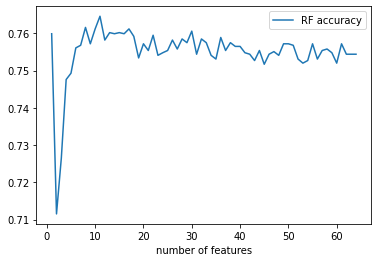

In [ ]:
Accuracy_table.plot(x ='number of features', y='RF accuracy')

Hence, we selected the top 11 features for random forest model 

In [ ]:
opt_feature=selected_features[0:11]
#opt_feature=['Win Odds','Season Stakes*','Dr.','Act.Wt.','Declar.Horse Wt.','Rtg.','NoofGear','Age','Dist.','Country of Origin_AUS ','Course_ "A"']

df_train, df_test = train_test_split(fdf,test_size=0.2)

pos_train = df_train["Pla."]
x_train = df_train.iloc[:,7:].values
sx_train = df_train[opt_feature].values
y3_train = df_train["top3"]
y1_train = df_train["top1"]

pos_test = df_test["Pla."]
x_test = df_test.iloc[:,7:].values
sx_test = df_test[opt_feature].values
y3_test = df_test["top3"]
y1_test = df_test["top1"]

feature=df_train.columns[7:].values

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(sx_train, y3_train)
y3_pred=rf_clf.predict(sx_test)
print('Accuracy for top 3 with 11 selectd features:', accuracy_score(y3_test, y3_pred).round(4))

Accuracy for top 3 with 11 selectd features: 0.7568


In [ ]:
Outcome=pd.DataFrame({'position':df_test["Pla."],'y3_pred':y3_pred,'y3_test':y3_test,'top 3 Win Odds':df_test['top3Winodd']})
Outcome['top 3 net'] = np.where(Outcome['y3_pred']==1,np.where(Outcome['y3_test']==1,(abs(Outcome['top 3 Win Odds']-1)*10),-10), 0)
Outcome

,position,y3_pred,y3_test,top 3 Win Odds,top 3 net
3126,14,0,0,0.0,0.0
1230,3,0,1,56.5,0.0
12491,6,0,0,0.0,0.0
9947,12,0,0,0.0,0.0
8518,1,0,1,37.0,0.0
...,...,...,...,...,...
14274,1,0,1,67.0,0.0
8366,6,0,0,0.0,0.0
730,5,0,0,0.0,0.0
12619,2,0,1,25.0,0.0


In [ ]:
Outcome[(Outcome["y3_pred"]==1) & (Outcome["y3_test"]==1)]

In [ ]:
Outcome[(Outcome["y3_pred"]==0) & (Outcome["y3_test"]==0)]

,position,y3_pred,y3_test,top 3 Win Odds,top 3 net
3126,14,0,0,0.0,0.0
12491,6,0,0,0.0,0.0
9947,12,0,0,0.0,0.0
5132,6,0,0,0.0,0.0
13184,11,0,0,0.0,0.0
...,...,...,...,...,...
14531,4,0,0,0.0,0.0
5225,13,0,0,0.0,0.0
8366,6,0,0,0.0,0.0
730,5,0,0,0.0,0.0


In [ ]:
Outcome.sum()

position          18815.0
y3_pred             542.0
y3_test             828.0
top 3 Win Odds    21485.0
top 3 net         38174.0
dtype: float64

In [ ]:
selected=selected_features[0:13]
df_train, df_test = train_test_split(fdf,test_size=0.2)

pos_train = df_train["Pla."]
sx_train = df_train[selected].values
y_train = df_train["top3"]

pos_test = df_test["Pla."]
sx_test = df_test[selected].values
y_test = df_test["top3"]

### 4. Model Consider hyperparameter tuning on 'top3'

In [ ]:
print('Parameters currently in use:\n')
print(rf_clf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]
}

clf = GridSearchCV(rf_model, model_params, cv=5)

model = clf.fit(sx_train, y_train)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [ ]:
print('Selected 11 features accuracy:', accuracy_score(y3_test, model.predict(sx_test)).round(4))

Selected 11 features accuracy: 0.7629


In [ ]:
Outcome=pd.DataFrame({'y_pred':model.predict(sx_test),'y_test':y3_test,'Win Odds':df_test['top3Winodd'],'position':df_test["Pla."]})
Outcome['net'] = np.where(Outcome['y_pred']==1,np.where(Outcome['y_test']==1,(abs(Outcome['Win Odds']-1)*10),-10), 0)
print(Outcome)
print(Outcome.sum())

       y_pred  y_test  Win Odds  position    net
5569        1       1      15.5         2  145.0
8558        0       0       0.0         8    0.0
12354       0       1       0.0         2    0.0
240         0       0       0.0         5    0.0
3795        1       1      22.5         3  215.0
...       ...     ...       ...       ...    ...
9392        0       0       0.0        12    0.0
3221        0       0       0.0         4    0.0
2146        0       0       0.0         4    0.0
944         0       1      16.5         3    0.0
11857       0       0       0.0         7    0.0

[2936 rows x 5 columns]
y_pred        487.0
y_test        805.0
Win Odds    23097.4
position    18848.0
net         36454.0
dtype: float64


When the y_pred =1, we will pay 10HKD for betting, if y_test =1, that means our prediction is correct, the horse is in the top3 places, we will get 'Win Odds'*10, which mean we will have (winodd-1)*10 return.
if we pay 10HKD and the horse does not win, we lose 10HKD so the 'net'column = -10
If the y_pred =0, our model predict the horse can not win in the 'place' betting system and hence we will not bet on it. The corresponding 'net' column will be 0

### Model consider variable importance: classifer on 'top1'



In [ ]:
#pip install eli5import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(x_train, y1_train)
perm = PermutationImportance(rf_clf).fit(x_train, y1_train)
eli5.show_weights(perm, feature_names=feature)

Weight,Feature
0.0782 ± 0.0035,Win Odds
0.0534 ± 0.0035,Season Stakes*
0.0401 ± 0.0016,Dr.
0.0336 ± 0.0013,Declar.Horse Wt.
0.0324 ± 0.0018,Act.Wt.
0.0240 ± 0.0018,Rtg.
0.0177 ± 0.0015,Age
0.0166 ± 0.0006,NoofGear
0.0148 ± 0.0007,Dist.
0.0074 ± 0.0012,Country of Origin_AUS


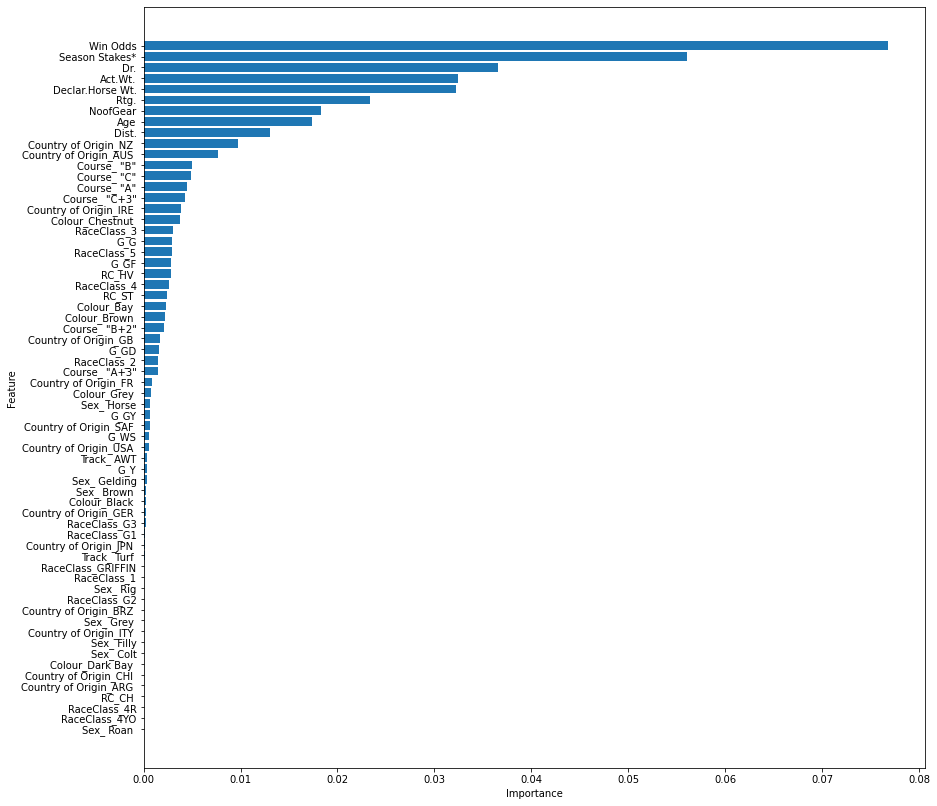

In [ ]:
# importance in decreasing order
imp_ord = np.argsort(perm.feature_importances_)

plt.figure(figsize=(14,14))
yaxis = np.arange(len(perm.feature_importances_))*1
plt.barh(y = yaxis,width = perm.feature_importances_[imp_ord])
plt.yticks(yaxis,feature[imp_ord])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

In [ ]:
top1_importance_table=pd.DataFrame({'features':feature[imp_ord],'importance':perm.feature_importances_[imp_ord]})
print(top1_importance_table.to_string())

                  features  importance
0               Sex_ Roan     0.000085
1                   RC_CH     0.000000
2               Track_ AWT    0.000545
3                 Sex_ Rig    0.000085
4             RaceClass_G1    0.000256
5   Country of Origin_CHI     0.000085
6   Country of Origin_GER     0.000392
7   Country of Origin_ITY     0.000000
8   Country of Origin_BRZ     0.000170
9   Country of Origin_JPN     0.000085
10              Sex_ Filly    0.000000
11              Sex_ Grey     0.000000
12               Sex_ Colt    0.000000
13  Country of Origin_ARG     0.000000
14             RaceClass_1    0.000256
15            Track_ Turf     0.000937
16              Sex_ Horse    0.000426
17            RaceClass_4R    0.000000
18           RaceClass_4YO    0.000000
19            RaceClass_G3    0.000256
20            RaceClass_G2    0.000170
21            Sex_ Gelding    0.000238
22                     G_Y    0.000426
23            Colour_Grey     0.000971
24       RaceClass_GRIFFI

In [ ]:
#we select the features with importance > 0.01
selected=["NoofGear", "Dist.","Age","Rtg.", "Act.Wt.","Declar.Horse Wt.","Dr.", "Season Stakes*", "Win Odds"]
#selected=importance_table[importance_table['importance']>0.01]["features"]
sx_train = df_train[selected].values
sx_test = df_test[selected].values

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(sx_train, y1_train)
y1_pred=rf_clf.predict(sx_test)
print('Accuracy:', accuracy_score(y1_test, y1_pred).round(4))

Accuracy: 0.9026


In [ ]:
Outcome=pd.DataFrame({'y_pred':y1_pred,'y1_test':y1_test,'Win Odds':df_test['Win Odds'],'position':df_test["Pla."]})
Outcome['net'] = np.where(Outcome['y_pred']==1,np.where(Outcome['y1_test']==1,(Outcome['Win Odds']-1)*10,-10), 0)
Outcome

,y_pred,y1_test,Win Odds,position,net
7555,0,0,26.0,4,0.0
1505,0,0,5.5,8,0.0
8722,0,0,90.0,10,0.0
11164,0,0,9.4,3,0.0
8054,0,0,9.8,5,0.0
...,...,...,...,...,...
11919,0,0,43.0,6,0.0
1358,0,0,9.5,8,0.0
6611,0,1,9.0,1,0.0
12219,0,0,2.6,4,0.0


In [ ]:
Outcome.sum()

y_pred          52.0
y1_test        286.0
Win Odds    118469.2
position     18539.0
net              6.0
dtype: float64

### Model consider variable importance and interaction effect: classifer on 'top1'

In [ ]:
selected_features=[]
accuracy=[]

df_train, df_test = train_test_split(fdf,test_size=0.2)
y_train = df_train["top1"]
y_test = df_test["top1"]

for i in range (-1, -65, -1):
  print("Adding", feature[imp_ord][i])
  selected_features.append(feature[imp_ord][i])
  x_train=df_train[selected_features].values
  x_test=df_test[selected_features].values
  rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
  rf_clf.fit(x_train, y_train)
  accuracy.append(accuracy_score(y_test, rf_clf.predict(x_test)).round(4))
  print('selected :',len(selected_features),'Accuracy : ', accuracy_score(y_test, rf_clf.predict(x_test)).round(4))
  print("="*20)

Adding Win Odds
selected : 1 Accuracy :  0.9084
Adding Season Stakes*
selected : 2 Accuracy :  0.8873
Adding Dr.
selected : 3 Accuracy :  0.8917
Adding Act.Wt.
selected : 4 Accuracy :  0.9022
Adding Declar.Horse Wt.
selected : 5 Accuracy :  0.907
Adding Rtg.
selected : 6 Accuracy :  0.9067
Adding NoofGear
selected : 7 Accuracy :  0.9067
Adding Age
selected : 8 Accuracy :  0.9067
Adding Dist.
selected : 9 Accuracy :  0.9084
Adding Country of Origin_NZ 
selected : 10 Accuracy :  0.9077
Adding Country of Origin_AUS 
selected : 11 Accuracy :  0.9067
Adding Course_ "B"
selected : 12 Accuracy :  0.9074
Adding Course_ "C"
selected : 13 Accuracy :  0.9077
Adding Course_ "A"
selected : 14 Accuracy :  0.9091
Adding Course_ "C+3"
selected : 15 Accuracy :  0.9084
Adding Country of Origin_IRE 
selected : 16 Accuracy :  0.908
Adding Colour_Chestnut 
selected : 17 Accuracy :  0.9063
Adding RaceClass_3
selected : 18 Accuracy :  0.9057
Adding G_G
selected : 19 Accuracy :  0.9063
Adding RaceClass_5
sele

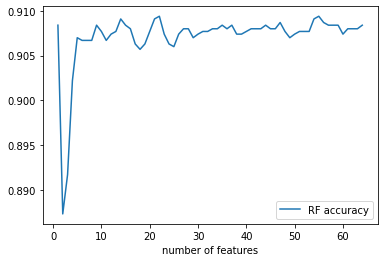

In [ ]:
list=[]
for i in range (1, 65):
  list.append(i)
Accuracy_table=pd.DataFrame({'number of features':list,'RF accuracy':accuracy})
Accuracy_table.plot(x ='number of features', y='RF accuracy')

In [ ]:
opt_feature=selected_features[0:14]
opt_feature

['Win Odds',
 'Season Stakes*',
 'Dr.',
 'Act.Wt.',
 'Declar.Horse Wt.',
 'Rtg.',
 'NoofGear',
 'Age',
 'Dist.',
 'Country of Origin_NZ ',
 'Country of Origin_AUS ',
 'Course_ "B"',
 'Course_ "C"',
 'Course_ "A"']

The maximum accuracy is attained when 14 variables are included. The accuracy  = 0.9091

In [ ]:
# calculate the award based on the existing model

opt_selected=['Win Odds','Season Stakes*','Dr.','Act.Wt.','Declar.Horse Wt.','Rtg.','NoofGear',
 'Age','Dist.','Country of Origin_NZ ','Country of Origin_AUS ','Course_ "B"','Course_ "C"','Course_ "A"']

df_train, df_test = train_test_split(fdf,test_size=0.2)

pos_train = df_train["Pla."]
sx_train = df_train[opt_selected].values
y1_train = df_train["top1"]

pos_test = df_test["Pla."]
sx_test = df_test[opt_selected].values
y1_test = df_test["top1"]

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(sx_train, y1_train)
y1_pred=rf_clf.predict(sx_test)
print('Accuracy:', accuracy_score(y1_test, y1_pred).round(4))

Accuracy: 0.9094


In [ ]:
Outcome=pd.DataFrame({'y_pred':y1_pred,'y1_test':y1_test,'Win Odds':df_test['Win Odds'],'position':df_test["Pla."]})
Outcome['net'] = np.where(Outcome['y_pred']==1,np.where(Outcome['y1_test']==1,(Outcome['Win Odds']-1)*10,-10), 0)
Outcome

,y_pred,y1_test,Win Odds,position,net
9765,0,0,8.2,2,0.0
14309,0,0,9.5,7,0.0
13831,0,0,7.7,7,0.0
13482,0,0,3.4,2,0.0
1843,0,1,15.0,1,0.0
...,...,...,...,...,...
7161,0,1,3.0,1,0.0
8083,0,0,27.0,10,0.0
11749,0,0,166.0,10,0.0
10420,0,0,9.2,3,0.0


In [ ]:
Outcome.sum()

y_pred          38.0
y1_test        266.0
Win Odds    118476.5
position     18746.0
net            -32.0
dtype: float64

### Model consider hyperparameter tuning on 'top1'

In [ ]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]
}

clf = GridSearchCV(rf_model, model_params, cv=5)

model = clf.fit(sx_train, y1_train)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [ ]:
print('Selected 14 features accuracy:', accuracy_score(y1_test, model.predict(sx_test)).round(4))

Selected 14 features accuracy: 0.9029


In [ ]:
Outcome=pd.DataFrame({'y_pred':model.predict(sx_test),'y_test':y1_test,'Win Odds':df_test['Win Odds'],'position':df_test["Pla."]})
Outcome['net'] = np.where(Outcome['y_pred']==1,np.where(Outcome['y_test']==1,(abs(Outcome['Win Odds']-1)*10),-10), 0)
print(Outcome)
print(Outcome.sum())

       y_pred  y_test  Win Odds  position  net
7555        0       0      26.0         4  0.0
1505        0       0       5.5         8  0.0
8722        0       0      90.0        10  0.0
11164       0       0       9.4         3  0.0
8054        0       0       9.8         5  0.0
...       ...     ...       ...       ...  ...
11919       0       0      43.0         6  0.0
1358        0       0       9.5         8  0.0
6611        0       1       9.0         1  0.0
12219       0       0       2.6         4  0.0
11555       0       0      26.0         8  0.0

[2936 rows x 5 columns]
y_pred          33.0
y_test         286.0
Win Odds    118469.2
position     18539.0
net              8.0
dtype: float64


## Neural Network (Approach: Place)

### Hyperparameter tuning

In [22]:
# Load the dataset
from sklearn.neural_network import MLPClassifier
full_data = pd.read_csv("drive/MyDrive/COMP3359 Project/full_data_update.csv")

# split the features and expected result
y_df = full_data[["top3"]]
y_df["class"] = y_df["top3"]
x_df = full_data.drop(["horse", "N_RaceIndex", "Pla.", "Finish Time", "top3", "top1"], axis = 1)
y_df.drop(["top3"], axis=1, inplace=True)

# split the train set and test set
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size = 0.2)
train_outcome = train_x[["top3Winodd"]]
test_outcome = test_x[["top3Winodd"]]
train_x.drop(["top3Winodd"], axis=1, inplace=True)
test_x.drop(["top3Winodd"], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Hyperparameter tuning (Do not run this cell)
scores = []
for i in range(1, 5):
    model = MLPClassifier(hidden_layer_sizes=i*100, batch_size=36).fit(train_x, train_y)
    scores.append(model.score(test_x, test_y))

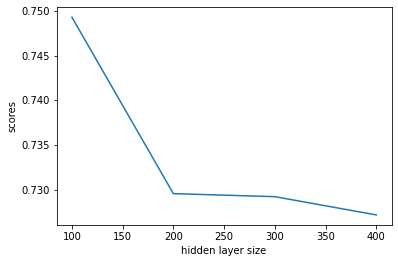

In [ ]:
# Hyperparameter tuning (Do not run this cell)
import matplotlib.pyplot as plt
plt.plot([100, 200, 300, 400], scores)
plt.ylabel("scores")
plt.xlabel("hidden layer size")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizati

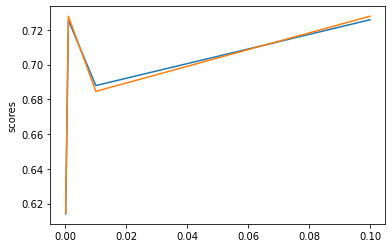

In [ ]:
# Hyperparameter tuning (Do not run this cell)
scores = []
for i in [0.0001, 0.001, 0.01, 0.1]:
    model = MLPClassifier(hidden_layer_sizes=100, learning_rate_init=i, batch_size=36).fit(train_x, train_y)
    scores.append([model.score(train_x, train_y), model.score(test_x, test_y)])

import matplotlib.pyplot as plt
plt.plot([0.0001, 0.001, 0.01, 0.1], scores)
plt.ylabel("scores")
plt.annotate
plt.show()

In [ ]:
# Hyperparameter tuning (Do not run this cell)
from sklearn.model_selection import GridSearchCV

selected=['Win Odds','Season Stakes*','Dr.','Declar.Horse Wt.','Act.Wt.','Rtg.','Age','NoofGear','Dist.','Country of Origin_AUS ','Country of Origin_NZ ','Country of Origin_IRE ']
train_x_2 = train_x[selected]
test_x_2 = test_x[selected]

parameter_space = {
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

model = MLPClassifier(hidden_layer_sizes=200, solver="sgd", activation="tanh", alpha=0.0001, max_iter=1)

clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5)
clf.fit(train_x_2, train_y)
print(clf.best_params_)

{'activation': 'tanh', 'alpha': 0.0001, 'learning_rate': 'constant', 'solver': 'sgd'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# NN Model Result (Predicting Place (Top 3))
# Do not run this cell
model = MLPClassifier(hidden_layer_sizes=100, solver="sgd", activation="tanh", alpha=0.0001, early_stopping=True).fit(train_x, train_y)
predict = model.predict(test_x)
print(model.score(train_x, train_y))
print(model.score(test_x, test_y))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7258325525934759
0.7278610354223434


In [ ]:
# NN Model Result (Predicting Place (Top 1))
# Do not run this cell
predict = model.predict_proba(test_x)
temp = pd.DataFrame(predict, columns=["0", "1"])

print(model.score(test_x, test_y))
temp.describe()

0.9053133514986376


,0,1
count,2936.000000,2936.000000
mean,0.892446,0.107554
std,0.022164,0.022164
min,0.830381,0.034561
25%,0.883954,0.116046
50%,0.883954,0.116046
75%,0.883954,0.116046
max,0.965439,0.169619


### Model

In [23]:
# Select the important features only
selected=['Win Odds','Season Stakes*','Dr.','Declar.Horse Wt.','Act.Wt.','Rtg.','Age','NoofGear','Dist.','Country of Origin_AUS ','Country of Origin_NZ ','Country of Origin_IRE ']
train_x_2 = train_x[selected]
test_x_2 = test_x[selected]

In [24]:
# NN Model (Predicting Place(Top 3))
model = MLPClassifier(hidden_layer_sizes=100, solver="sgd", activation="tanh", alpha=0.0001, early_stopping=True).fit(train_x_2, train_y)
predict = model.predict(test_x_2)
print("Example result: Class " + str(predict[0]))
print("Real value : Class " + str(test_y.iloc[0]["class"]))
print(model.score(train_x_2, train_y))
print(model.score(test_x_2, test_y))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Example result: Class 0
Real value : Class 1
0.727195298526531
0.7224114441416893


In [ ]:
# Build a new DataFrame to count net gain/loss 
outcome = pd.DataFrame({'pred':predict,'Real':test_y["class"],'Win Odds':test_outcome["top3Winodd"]})
outcome

,pred,Real,Win Odds
2832,0,0,NaN
9035,0,0,NaN
10928,0,0,NaN
10294,0,0,NaN
5246,0,0,NaN
...,...,...,...
7692,0,0,NaN
5267,0,1,42.5
2559,0,0,NaN
12538,0,1,21.5


In [ ]:
# Count the net gain/loss
outcome["Win Odds"].fillna(0.0, inplace=True)
outcome['net'] = np.where(outcome['pred']==1, np.where(outcome['Real']==1, abs((outcome["Win Odds"] - 1)*10), -10), 0)
outcome

,pred,Real,Win Odds,net
2832,0,0,1.0,0.0
9035,0,0,1.0,0.0
10928,0,0,1.0,0.0
10294,0,0,1.0,0.0
5246,0,0,1.0,0.0
...,...,...,...,...
7692,0,0,1.0,0.0
5267,0,1,42.5,0.0
2559,0,0,1.0,0.0
12538,0,1,21.5,0.0


In [ ]:
outcome["net"].sum()

0.0

In [ ]:
sum(outcome["pred"]==1)
# In this cell, we found that the model is not learning

0

## Neural Network (Approach: Time)

### Prepare Data

In [25]:
# Selecting the features for predicting finish time
import random

# read the data set
data_df = pd.read_csv("drive/MyDrive/COMP3359 Project/full_data_update.csv")

# Normalize Dist. and season stakes
data_df["Season Stakes*"] = data_df["Season Stakes*"] / 100000
data_df["Dist."] = (data_df["Dist."] - 1000) / 1400

# Drop the uneless columns and columns which may interfer the model
data_df.drop(["Pla.", "horse", "N_RaceIndex", "top3", "top1", "top3Winodd"], axis=1, inplace=True)
for col in data_df.select_dtypes(include=['object']).columns:
    data_df[col] = data_df[col].astype('category')
for col in data_df.select_dtypes(include=['category']).columns:
    data_df[col] = data_df[col].cat.codes

RAND_SEED = 3359
TRAIN_SIZE = 0.8

all_index = list(range(len(data_df)))

random.seed(RAND_SEED)
random.shuffle(all_index)

train_size = int(len(data_df) * TRAIN_SIZE)
train_idx = all_index[:train_size]
test_idx = all_index[train_size:]

# Split the train and test set
x_data_df, y_data_df = data_df.drop(["Finish Time"], axis=1), data_df["Finish Time"]
train_x, test_x = x_data_df.iloc[train_idx], x_data_df.iloc[test_idx]
train_y, test_y = y_data_df.iloc[train_idx], y_data_df.iloc[test_idx]

train_x = train_x.reset_index()
test_x = test_x.reset_index()
train_y = train_y.reset_index()
test_y = test_y.reset_index()

train_y.drop(["index"], axis=1, inplace=True)
test_y.drop(["index"], axis=1, inplace=True)
train_x.drop(["index"], axis=1, inplace=True)
test_x.drop(["index"], axis=1, inplace=True)

# select the important features 
selected=['Win Odds','Season Stakes*','Dr.','Declar.Horse Wt.','Act.Wt.','Rtg.','Age','NoofGear','Dist.','Country of Origin_AUS ','Country of Origin_NZ ','Country of Origin_IRE ']
train_x_2 = train_x[selected]
test_x_2 = test_x[selected]

In [ ]:
test_x

,Dist.,Dr.,Rtg.,Win Odds,Act.Wt.,Declar.Horse Wt.,NoofGear,Season Stakes*,Age,G_G,G_GD,G_GF,G_GY,G_WS,G_Y,RaceClass_1,RaceClass_2,RaceClass_3,RaceClass_4,RaceClass_4R,RaceClass_4YO,RaceClass_5,RaceClass_G1,RaceClass_G2,RaceClass_G3,RaceClass_GRIFFIN,RC_CH,RC_HV,RC_ST,Track_ AWT,Track_ Turf,"Course_ ""A""","Course_ ""A+3""","Course_ ""B""","Course_ ""B+2""","Course_ ""C""","Course_ ""C+3""",Country of Origin_ARG,Country of Origin_AUS,Country of Origin_BRZ,Country of Origin_CHI,Country of Origin_FR,Country of Origin_GB,Country of Origin_GER,Country of Origin_IRE,Country of Origin_ITY,Country of Origin_JPN,Country of Origin_NZ,Country of Origin_SAF,Country of Origin_USA,Colour_Bay,Colour_Black,Colour_Brown,Colour_Chestnut,Colour_Dark Bay,Colour_Grey,Sex_ Brown,Sex_ Colt,Sex_ Filly,Sex_ Gelding,Sex_ Grey,Sex_ Horse,Sex_ Rig,Sex_ Roan
0,0.142857,12,71.0,37.0,124,1037.0,1,9.2250,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.285714,6,58.0,2.5,133,1080.0,2,14.7000,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0.000000,13,65.0,14.0,118,1238.0,1,8.6900,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0.285714,4,75.0,18.0,128,1075.0,3,17.8500,7,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.285714,5,78.0,3.4,131,1101.0,1,9.0950,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2931,0.285714,2,54.0,7.9,124,1068.0,0,0.2625,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2932,0.285714,1,79.0,3.3,132,1210.0,0,1.7250,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2933,0.142857,1,46.0,13.0,116,1105.0,0,9.2000,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2934,0.285714,11,90.0,8.2,125,1168.0,8,0.0000,7,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


### Experiment & Parameters Tuning

In [26]:
# Import the libs for this section
from sklearn.neural_network import MLPRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


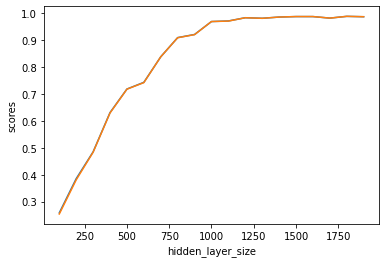

In [ ]:
# Experiment(Don't Run this cell)
scores = []
index = []
for i in range(1, 20):
    model = MLPRegressor(hidden_layer_sizes=i*100, random_state=RAND_SEED, batch_size="auto").fit(train_x_2, train_y)
    scores.append([model.score(train_x_2, train_y), model.score(test_x_2, test_y)])
    index.append(i*100)

import matplotlib.pyplot as plt
plt.plot(index, scores)
plt.ylabel("scores")
plt.xlabel("hidden_layer_size")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

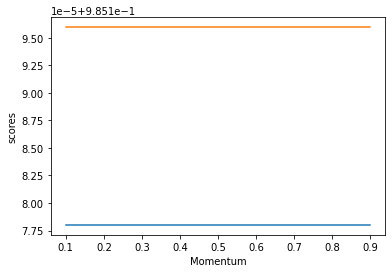

In [ ]:
# Experiment(Don't Run this cell)
scores = []
index = []
for i in range(1, 10):
    model = MLPRegressor(hidden_layer_sizes=1250, random_state=RAND_SEED, batch_size="auto", momentum=i*0.1).fit(train_x_2, train_y)
    scores.append([model.score(train_x_2, train_y), model.score(test_x_2, test_y)])
    index.append(i*0.1)

import matplotlib.pyplot as plt
plt.plot(index, scores)
plt.ylabel("scores")
plt.xlabel("Momentum")
plt.show()

In [ ]:
# Hyperparameters tuning (Don't Run this cell)
from sklearn.model_selection import GridSearchCV

parameter_space = {
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

model = MLPRegressor(hidden_layer_sizes=1200)
clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5)
clf.fit(train_x_2, train_y)
print(clf.best_params_)

NameError: ignored

In [27]:
# NN Model (Predicting Time)
model = MLPRegressor(hidden_layer_sizes=1250, batch_size="auto", solver="adam", alpha=0.0001).fit(train_x_2, train_y)
print(model.score(train_x_2, train_y))
print(model.score(test_x_2, test_y))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9835107430726624
0.9834855347179524


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


From the table above, we can see that over 70% of the dataset are actually 